# Calibration of the preprocessing algorithm
IFT Preprocessing includes the following steps and tunable parameters.

| Step | Function | Parameters | Notes |
| --- | --- | --- | --- |
| 1 | Anisotropic Diffusion | | Perona and Malik (1990) algorithm |
| 2 | Tiled Adaptive Histogram | Tile size | |
|   |                          | Entropy threshold |  May depend on tile size|
|   |                          | White fraction thresholds | May depend on tile size|
| 3 | Reconstruct | Structuring element | Reconstruction with the hist-adj image |
| 4 | Sharpen | Radius | |
|   |         | Amount | |
| 5 | Reconstruct | Structuring element | Reconstruction with the sharpened image |
| 6 | Brighten Ice | Brighten Factor | Constrast adjustment using the green channel |
| 7 | Compute Residue | | Subtract the reconstructed image from the brightened image |
| 8 | Gamma Correction |  gamma | Uses the Images.adjust_histogram function with GammaCorrection algorithm |
|   |                  | gamma\_factor | |
|   |                  | gamma\_threshold | |


## Methods for calibration
We can vary the tile size, the thresholds for applying the adaptive histogram equalization, the sharpening settings, the choice of structuring elements, and the brightening factor. That's a total of 9 parameters.

In [2]:
using Pkg
Pkg.activate("calval")
using Images
using IceFloeTracker
using CairoMakie
using StatsBase
using CSV

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval`


In [3]:
# load validation images
data_loc = "../../ice_floe_validation_dataset/data/"
readdir(data_loc)

5-element Vector{String}:
 ".DS_Store"
 "masie"
 "metadata"
 "modis"
 "validation_dataset"

In [4]:
tc_paths = [c for c in readdir(joinpath(data_loc, "modis", "truecolor")) if occursin("tiff", c)];
cases = [split(c, ".")[1] for c in tc_paths]
fc_paths = [replace(c, "true"=>"false") for c in tc_paths];


Useful example cases:
- 061 (aqua). Large floes, patchy cloud obscuration.
- 001 (either). Large floe with heavy obscuration.

In [67]:
tc_paths[1*2 - 1]

"061-beaufort_sea-100km-20080613.aqua.truecolor.250m.tiff"

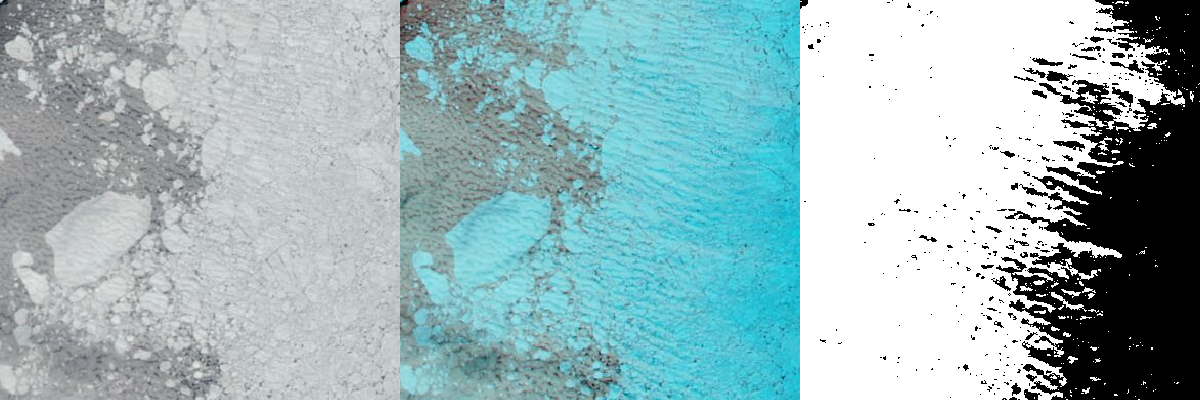

In [473]:
cn = 19
tc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "truecolor", tc_paths[cn*2 - 1]))
fc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "falsecolor", fc_paths[cn*2 - 1]))
cloudmask = .!IceFloeTracker.create_cloudmask(fc_img; prelim_threshold=53/255.,
    band_7_threshold=130/255.,
    band_2_threshold=169/255.,
    ratio_lower=0.0,
    ratio_upper=0.53)
Images.mosaicview(tc_img, fc_img, Gray.(cloudmask), nrow=1)

Test case 061, distinct ice floes with low-to-heavy cloud cover obscuration. First, let's look at the cloud fractions involved. If we break it down to 25 km tiles, that's 4 by 4 tiling, we get:

In [474]:
prelim_sizes = size(tc_img) .÷ 4
tiles = IceFloeTracker.get_tiles(tc_img, prelim_sizes[1] + 1);

cloud_fraction = zeros(size(tc_img))
b7_entropy = zeros(size(tc_img))
b1_entropy = zeros(size(tc_img))

for tile in tiles
    cloud_fraction[tile...] .= mean(cloudmask[tile...])
    b7_entropy[tile...] .= Images.entropy(red.(fc_img[tile...]))
    b1_entropy[tile...] .= Images.entropy(blue.(fc_img[tile...]))
end

# # Get clouds_red for adaptive histogram equalization
# fc_img_cloudmasked = float64.(RGB.(fc_img))

# # fc_img_cloudmasked[cloudmask] .= 0
# clouds_red = IceFloeTracker.to_uint8(float64.(red.(fc_img_cloudmasked) .* 255));
# # clouds_red[.!landmask.dilated] .= 0;


The clouds\_red object shows potential clouds over sea ice.

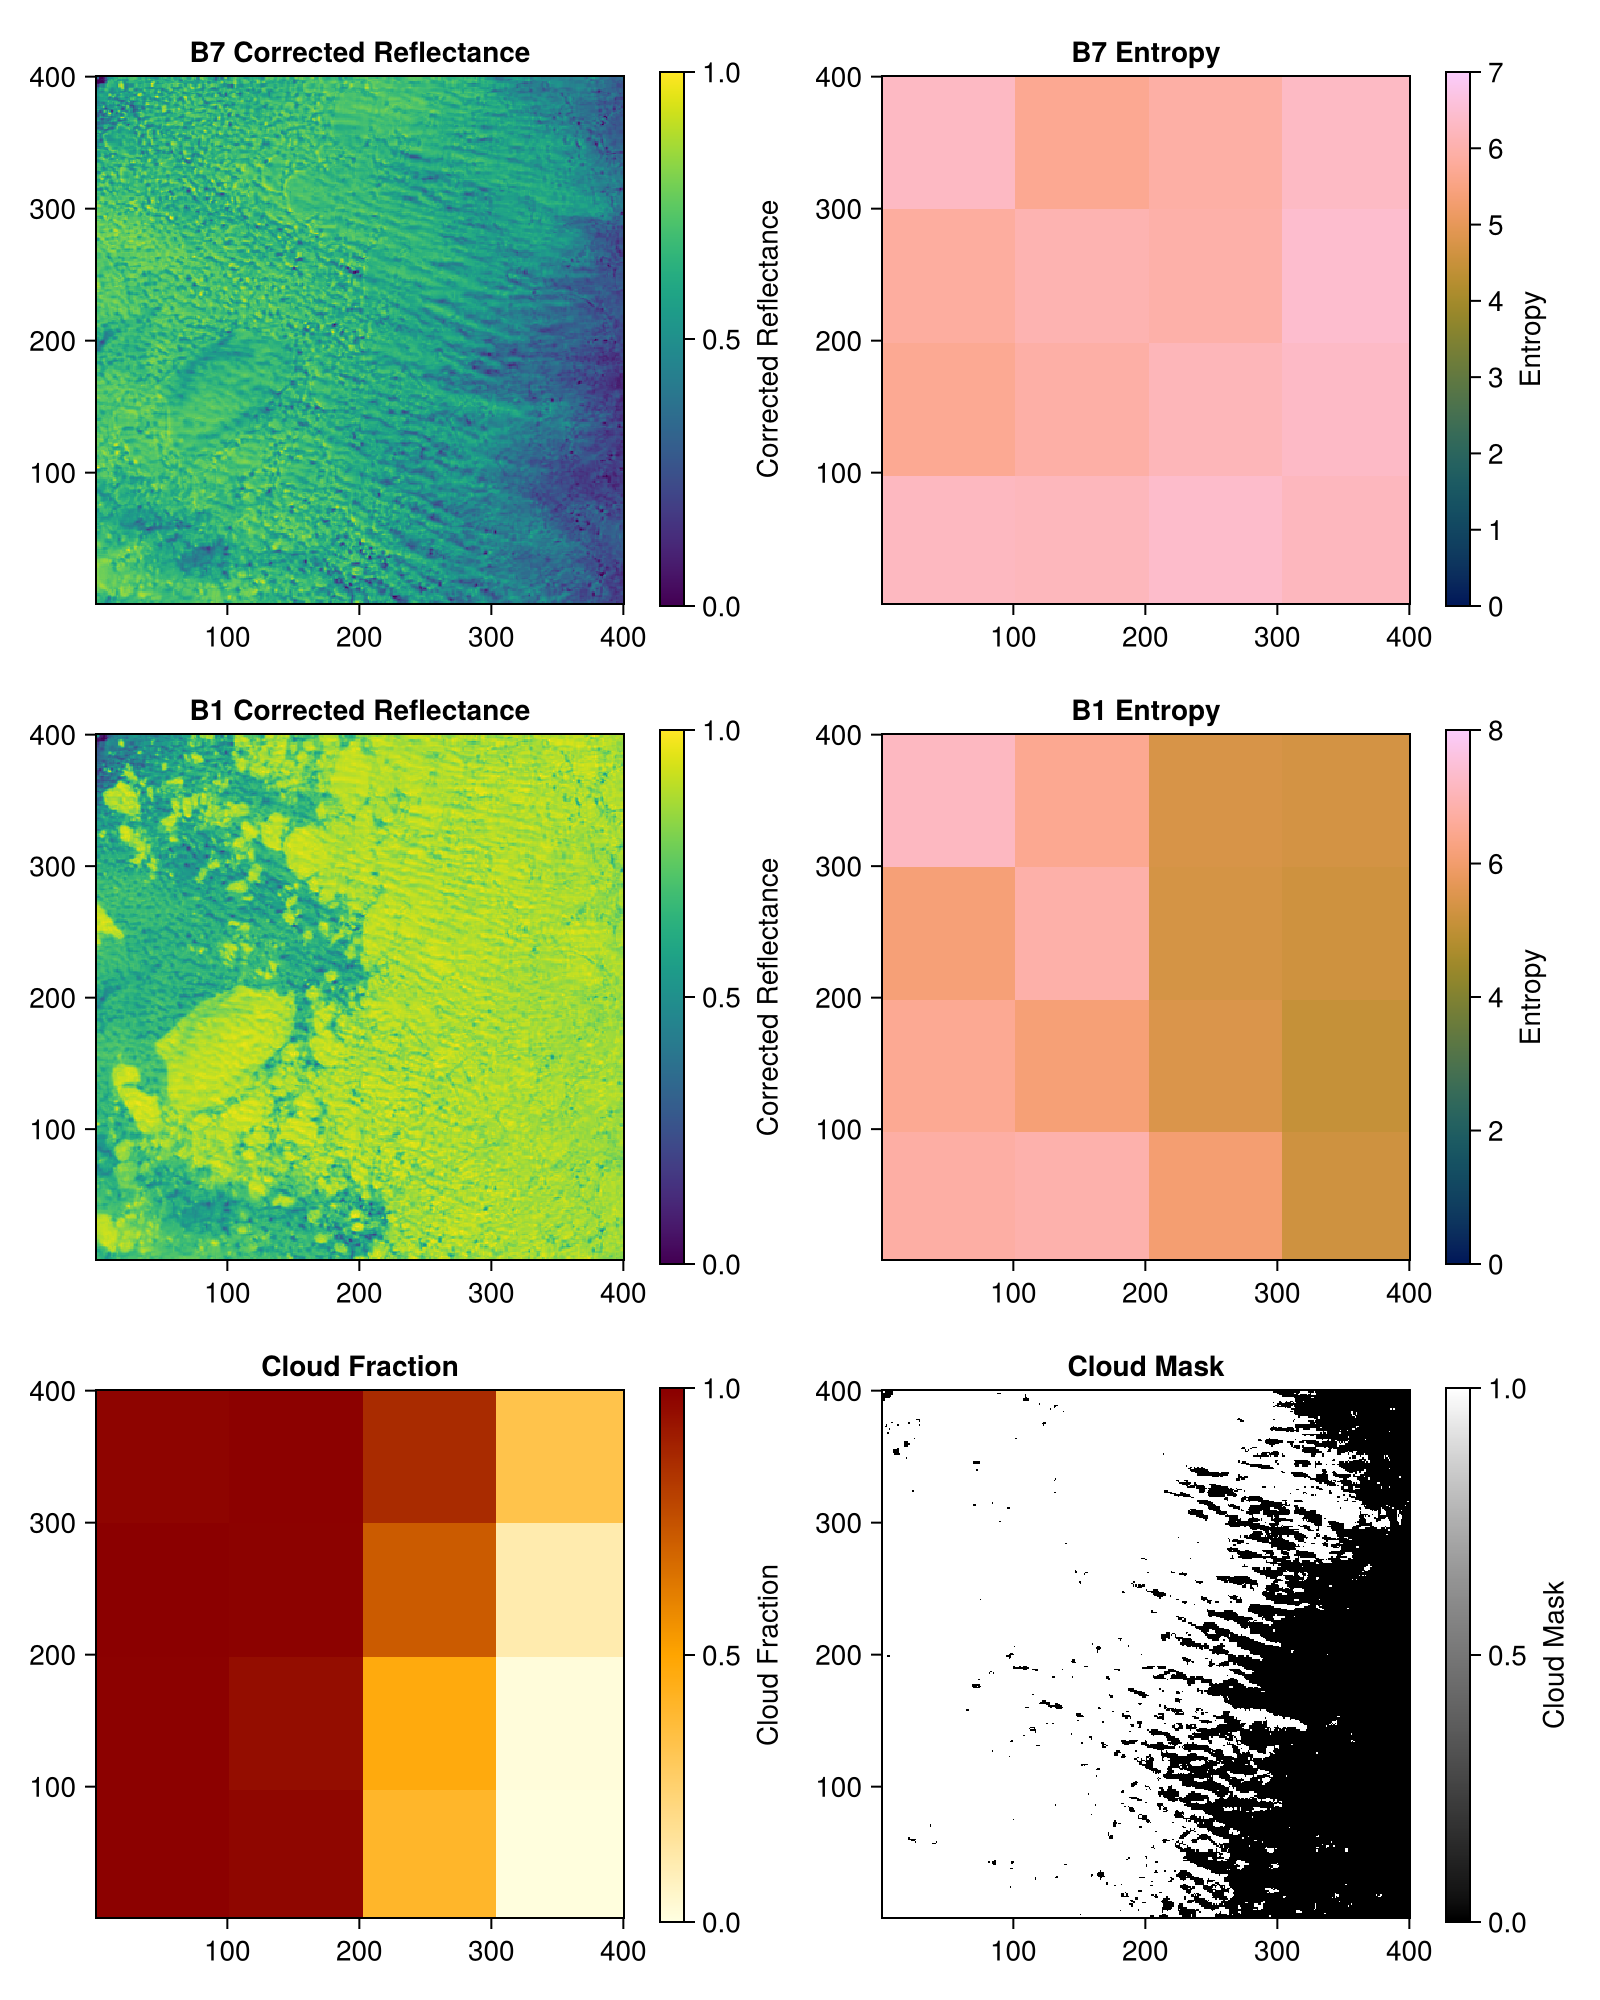

In [475]:
# Images.mosaicview(Gray.(clouds_red / 255), Gray.(green.(fc_img)))

f = Figure(size=(800, 1000))

ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title="B7 Corrected Reflectance")
ax2 = CairoMakie.Axis(f[1, 3], aspect = 1, title="B7 Entropy")
ax3 = CairoMakie.Axis(f[2, 1], aspect = 1, title="B1 Corrected Reflectance")
ax4 = CairoMakie.Axis(f[2, 3], aspect = 1, title="B1 Entropy")
ax5 = CairoMakie.Axis(f[3, 1], aspect = 1, title="Cloud Fraction")
ax6 = CairoMakie.Axis(f[3, 3], aspect = 1, title="Cloud Mask")

heatmap!(ax1, transpose(red.(fc_img)[end:-1:1,:]),)
Colorbar(f[1, 2], limits=(0, 1),
    vertical=true, label="Corrected Reflectance")

heatmap!(ax2, transpose(b7_entropy[end:-1:1,:]), colormap=:batlow, colorrange=(0, ceil(maximum(b7_entropy))))
Colorbar(f[1, 4], limits=(0, ceil(maximum(b7_entropy))), colormap=:batlow,
    vertical=true, label="Entropy")

heatmap!(ax3, transpose(blue.(fc_img)[end:-1:1,:]),)
Colorbar(f[2, 2], limits=(0, 1),
    vertical=true, label="Corrected Reflectance")

heatmap!(ax4, transpose(b1_entropy[end:-1:1,:]), colormap=:batlow, colorrange=(0, ceil(maximum(b1_entropy))))
Colorbar(f[2, 4], limits=(0, ceil(maximum(b1_entropy))), colormap=:batlow,
    vertical=true, label="Entropy")


heatmap!(ax5, transpose(cloud_fraction[end:-1:1,:]), colormap=:heat, colorrange=(0, 1))
Colorbar(f[3, 2], limits=(0, 1), colormap=:heat,
    vertical=true, label="Cloud Fraction")

heatmap!(ax6, transpose(cloudmask[end:-1:1,:]), colormap=:grayC, colorrange=(0, 1))
Colorbar(f[3, 4], limits=(0, 1), colormap=:grayC,
    vertical=true, label="Cloud Mask")


f


In [125]:
lm_img = IceFloeTracker.load(joinpath(data_loc, "modis", "landmask", replace(fc_paths[1], "falsecolor"=>"landmask")))
landmask = IceFloeTracker.create_landmask(lm_img)


(dilated = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1], non_dilated = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 1 1 … 1 1; 1 1 … 1 1])

# Setting the thresholds for the tiling

For each of the labeled images, get the cloud mask and compute the b1, b7 entropy. Record the fraction of the ice pixels that are obscured by the mask.

Entropy of the clouds\_red tile

In [359]:
using CSV
df = DataFrame(CSV.File("../data/validation_dataset_testtrain_split.csv"));
df_training = copy(df[df.training .&& (df.visible_floes .== "yes"),:]);

# initialize columns for each measure. We'll do the calculations on the whole dataset,
# then look at the performance with the train and test split.
df[!, "fraction_ice_floes_covered"] .= 0.
df[!, "mean_floe_b7_entropy"] .= 0.
df[!, "mean_floe_b1_entropy"] .= 0.
df[!, "mean_cloud_b7_entropy"] .= 0.
df[!, "mean_cloud_b1_entropy"] .= 0.
df[!, "image_mean_b7_entropy"] .= 0.
df[!, "image_mean_b1_entropy"] .= 0.
df[!, "image_min_b7_entropy"] .= 0.
df[!, "image_min_b1_entropy"] .= 0.
df[!, "image_max_b7_entropy"] .= 0.
df[!, "image_max_b1_entropy"] .= 0.
# image mean is computed for ocean pixels only

nothing

In [377]:
ntiles = 4
data_dir = "../../ice_floe_validation_dataset/data/"
for row_idx in range(1, size(df)[1])
    
    row = df[row_idx, :]
    case_number = lpad(row[:case_number], 3, "0")
    region = row[:region]
    satellite = row[:satellite]
    date = Dates.format(row[:start_date], "yyyymmdd")
    tc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "truecolor", "250m", "tiff"], ".")
    fc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "falsecolor", "250m", "tiff"], ".")
    lm_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "landmask", "250m", "tiff"], ".")    
    if df[row_idx, "visible_floes"] == "yes"
        global lb_filename = join([case_number, region, date, satellite, "binary_floes.png"], "-")
    end
    
    print(region, " ", row[:satellite], " ", case_number, "\n")

    lm_image = float64.(RGB.(load(joinpath(data_dir, "modis", "landmask", lm_filename))))
    fc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "falsecolor", fc_filename))))
    tc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "truecolor", tc_filename))))
    if df[row_idx, "visible_floes"] == "yes"
        global lb_image = RGB.(load(joinpath(data_dir, "validation_dataset", "binary_floes", lb_filename)))
        global man_labels = channelview(lb_image)[1,:,:] .> 0;
    end
    
    cloudmask = IceFloeTracker.create_cloudmask(fc_image; prelim_threshold=53/255.,
                band_7_threshold=130/255.,
                band_2_threshold=169/255.,
                ratio_lower=0.0,
                ratio_upper=0.53)
    
    # Default: Landmask has 1 = ocean, 0 = land
    landmask = IceFloeTracker.create_landmask(lm_image)
    landmask = landmask.non_dilated
      
    prelim_sizes = size(tc_image) .÷ ntiles
    tiles = IceFloeTracker.get_tiles(tc_image, prelim_sizes[1] + 1)

    cloud_fraction = zeros(size(tc_img))
    b7_entropy = zeros(size(tc_image))
    b1_entropy = zeros(size(tc_image))
    
    for tile in tiles        
        cloud_fraction[tile...] .= mean(cloudmask[tile...])
        b7_entropy[tile...] .= Images.entropy(red.(fc_image[tile...]))
        b1_entropy[tile...] .= Images.entropy(blue.(fc_image[tile...]))
    end

    ocean_idx = landmask .> 0
    
    
    df[row_idx, :fraction_ice_floes_covered] = mean(cloud_fraction[man_labels])
    df[row_idx, :image_mean_b7_entropy] = mean(b7_entropy[ocean_idx])
    df[row_idx, :image_mean_b1_entropy] = mean(b1_entropy[ocean_idx])
    df[row_idx, :image_min_b7_entropy] = minimum(b7_entropy[ocean_idx])
    df[row_idx, :image_min_b1_entropy] = minimum(b1_entropy[ocean_idx])
    df[row_idx, :image_max_b7_entropy] = maximum(b7_entropy[ocean_idx])
    df[row_idx, :image_max_b1_entropy] = maximum(b1_entropy[ocean_idx])

    
    if df[row_idx, "visible_floes"] == "yes"
        df[row_idx, :mean_floe_b7_entropy] = mean(b7_entropy[man_labels])
        df[row_idx, :mean_floe_b1_entropy] = mean(b1_entropy[man_labels])
    end

    idx = cloudmask .> 0 .&& ocean_idx
    if sum(idx) > 100
        df[row_idx, :mean_cloud_b7_entropy] = mean(b7_entropy[idx])
        df[row_idx, :mean_cloud_b1_entropy] = mean(b1_entropy[idx])
    end
end


baffin_bay terra 001
baffin_bay aqua 001
baffin_bay terra 002
baffin_bay aqua 002
baffin_bay terra 003
baffin_bay aqua 003
baffin_bay terra 004
baffin_bay aqua 004
baffin_bay terra 005
baffin_bay aqua 005
baffin_bay terra 006
baffin_bay aqua 006
baffin_bay aqua 007
baffin_bay terra 007
baffin_bay terra 008
baffin_bay aqua 008
baffin_bay terra 009
baffin_bay aqua 009
baffin_bay terra 010
baffin_bay aqua 010
baffin_bay aqua 011
baffin_bay terra 011
baffin_bay terra 012
baffin_bay aqua 012
baffin_bay aqua 013
baffin_bay terra 013
baffin_bay aqua 014
baffin_bay terra 014
baffin_bay terra 015
baffin_bay aqua 015
baffin_bay terra 016
baffin_bay aqua 016
baffin_bay aqua 017
baffin_bay terra 017
baffin_bay aqua 018
baffin_bay terra 018
baffin_bay terra 019
baffin_bay aqua 019
baffin_bay aqua 020
baffin_bay terra 020
baffin_bay terra 021
baffin_bay aqua 021
barents_kara_seas aqua 022
barents_kara_seas terra 022
barents_kara_seas aqua 023
barents_kara_seas terra 023
barents_kara_seas aqua 024
ba

Not yet analyzed: entropy in images with no floes visible

# Analysis results
1. Range of entropy values for sea ice floe pixels for no clouds, and for "light", "moderate", and "heavy" obscuration.

In [378]:
df_training = deepcopy(df[df.training .&& .! isnan.(df[:, :mean_floe_b1_entropy]), :]);


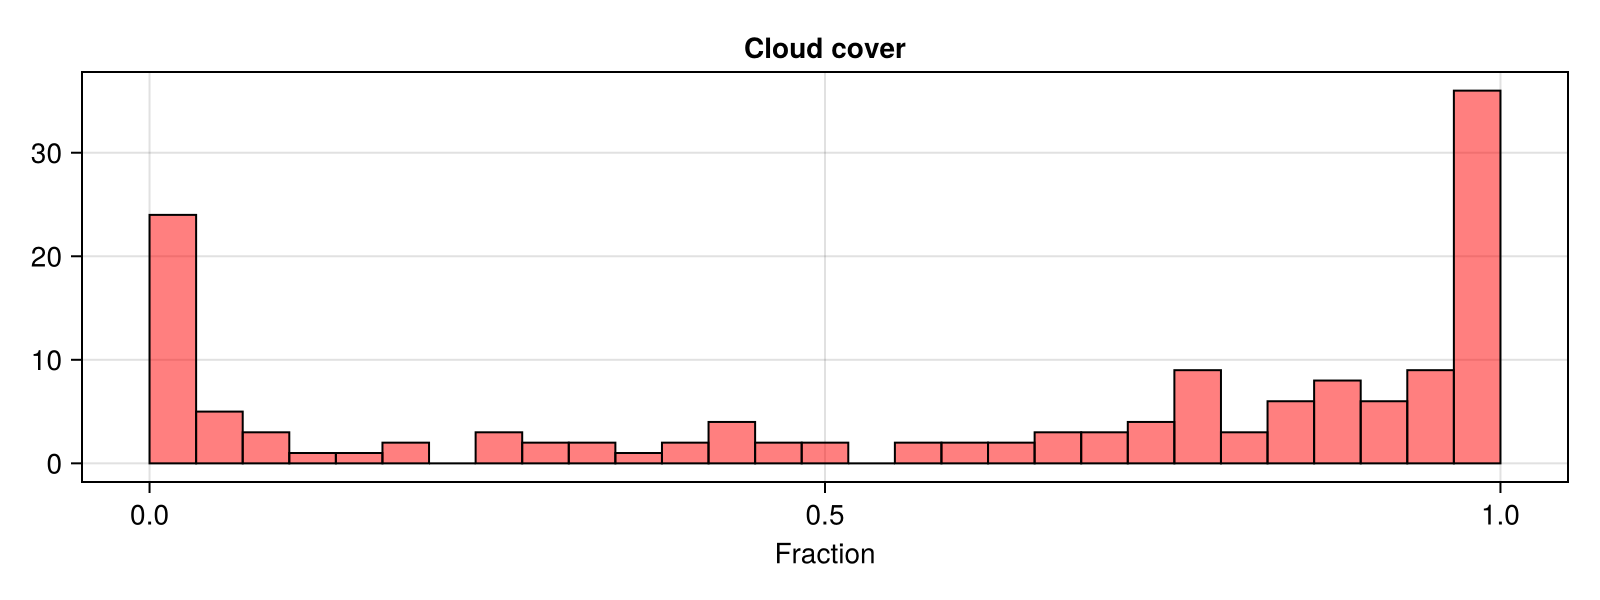

In [379]:

f = Figure(size=(800, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Cloud cover", xlabel="Fraction")

bins = range(0, 1, 30)
idx = df_training.visible_floes .== "yes"
hist!(ax1, df_training[idx, :fraction_ice_floes_covered], bins = bins,
    label = "Floes", strokewidth = 1, strokecolor = :black, color=(:red, 0.5))
f

Blue: Image mean, Red: Floe mean. Tile size=25 km

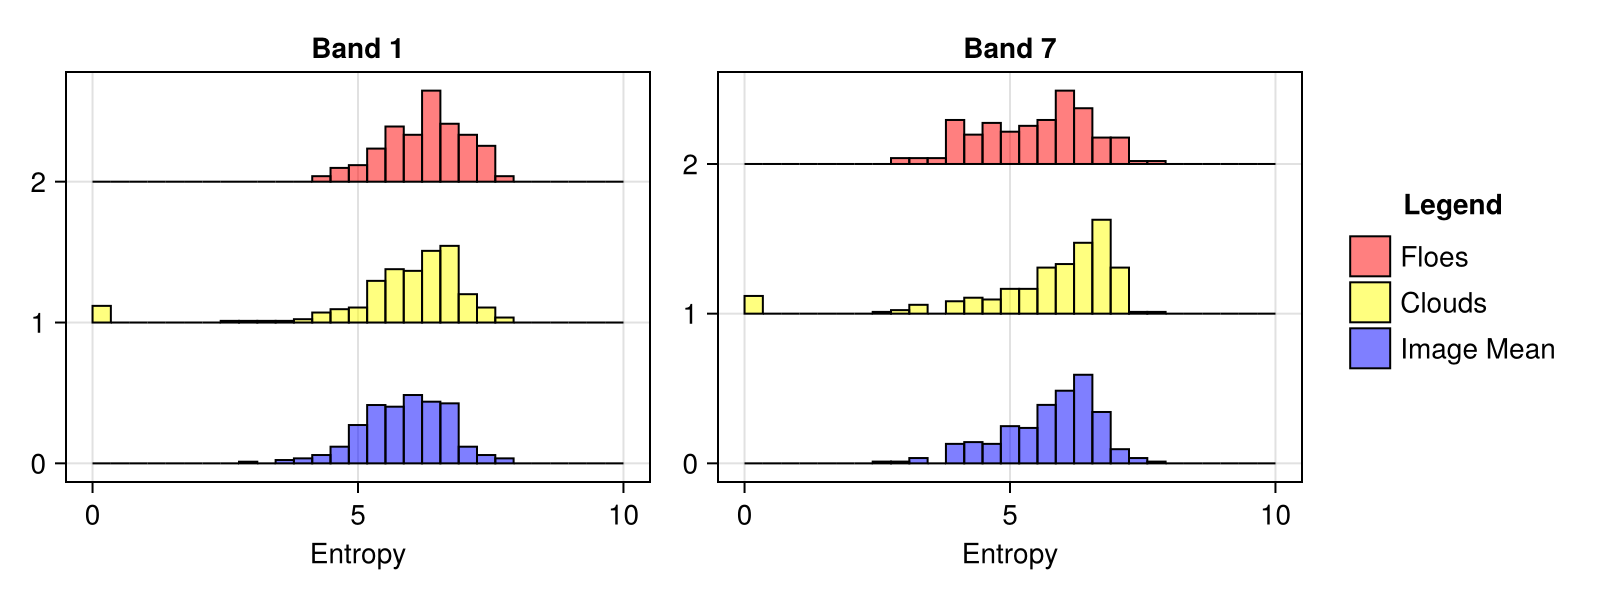

In [384]:

f = Figure(size=(800, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Band 1", xlabel="Entropy")
ax2 = CairoMakie.Axis(f[1,2], title="Band 7", xlabel="Entropy")

bins = range(0, 10, 30)
idx = df_training[:, :visible_floes] .== "yes"
hist!(ax1, df_training[idx, :mean_floe_b1_entropy], bins = bins, normalization = :pdf, offset=2,
    label = "Floes", strokewidth = 1, strokecolor = :black, color=(:red, 0.5))
hist!(ax2, df_training[idx, :mean_floe_b7_entropy], bins = bins, normalization = :pdf, offset=2,
    label="Floes", color = (:red, 0.5), strokewidth = 1, strokecolor = :black)

idx = df_training[:, :cloud_fraction_manual] .> 0
hist!(ax1, df_training[idx, :mean_cloud_b1_entropy], bins = bins, normalization = :pdf, offset=1,
    label = "Clouds", strokewidth = 1, strokecolor = :black, color=(:yellow, 0.5))
hist!(ax2, df_training[idx, :mean_cloud_b7_entropy], bins = bins, normalization = :pdf, offset=1,
    label="Clouds", color = (:yellow, 0.5), strokewidth = 1, strokecolor = :black)

hist!(ax1, df_training[idx, :image_mean_b1_entropy], bins = bins, normalization = :pdf,
    label = "Image Mean", strokewidth = 1, strokecolor = :black, color=(:blue, 0.5))
hist!(ax2, df_training[idx, :image_mean_b7_entropy], bins = bins, normalization = :pdf,
    label="Image Mean", color = (:blue, 0.5), strokewidth = 1, strokecolor = :black)
f[1,3] = Legend(f, ax1, "Legend", framevisible = false)

print("Blue: Image mean, Red: Floe mean. Tile size=25 km")
f

Blue: Moderate obscuration, Red: Heavy obscuration. Tile size=25 km

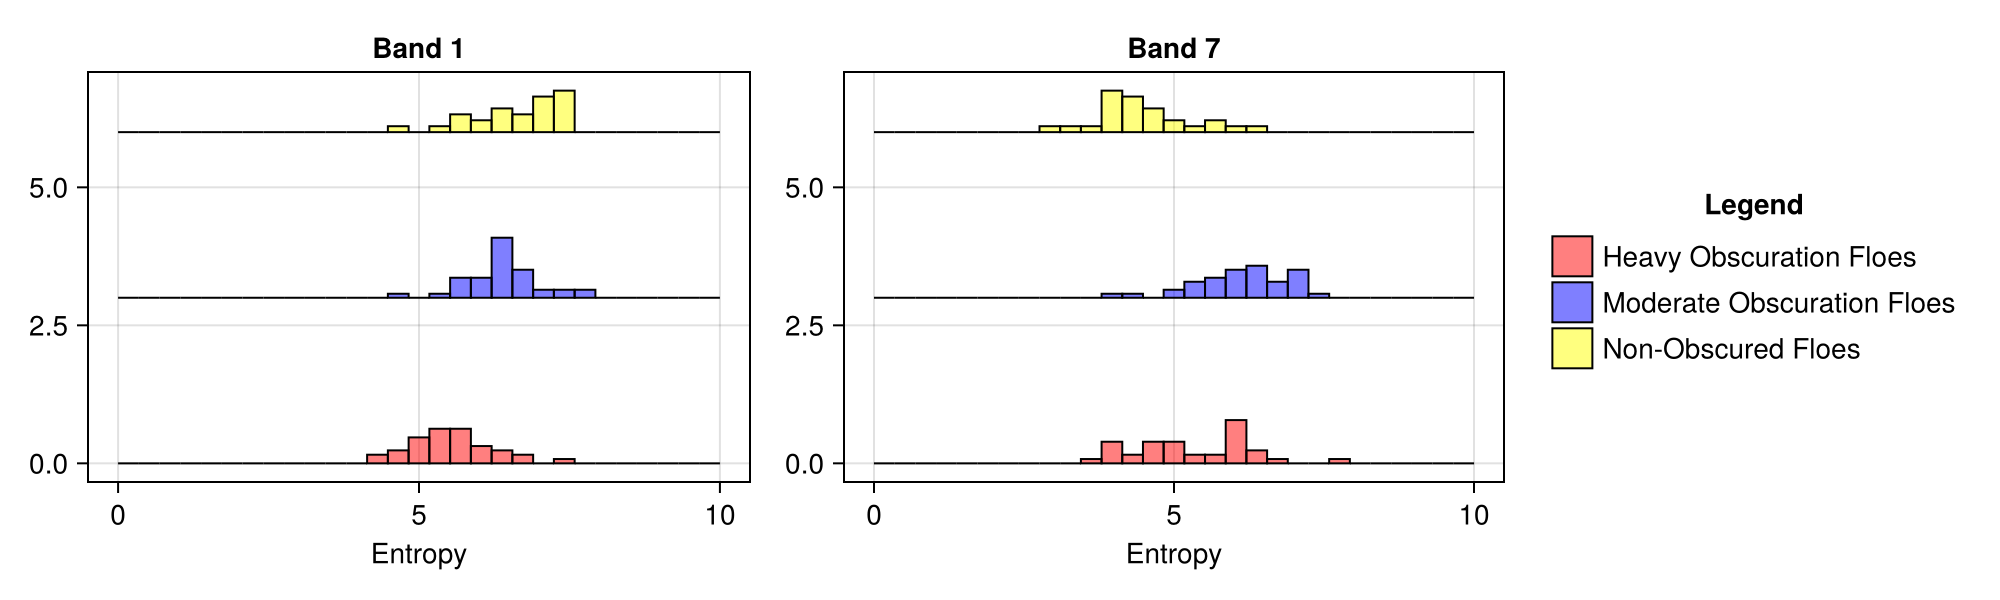

In [381]:
f = Figure(size=(1000, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Band 1", xlabel="Entropy")
ax2 = CairoMakie.Axis(f[1,2], title="Band 7", xlabel="Entropy")

bins = range(0, 10, 30)

df_ = df_training[df_training.visible_floes .== "yes", :]
idx = df_[:, :floe_obscuration] .== "heavy"
hist!(ax1, df_[idx, :mean_floe_b1_entropy], bins = bins,
    label = "Heavy Obscuration Floes", strokewidth = 1, strokecolor = :black, color=(:red, 0.5), normalization = :pdf)
hist!(ax2, df_[idx, :mean_floe_b7_entropy], bins = bins,
    label="Heavy Obscuration Floes", color = (:red, 0.5), strokewidth = 1, strokecolor = :black, normalization = :pdf)

idx = df_[:, :floe_obscuration] .== "moderate"
hist!(ax1, df_[idx, :mean_floe_b1_entropy], bins = bins, offset=3,
    label = "Moderate Obscuration Floes", strokewidth = 1, strokecolor = :black, color=(:blue, 0.5),  normalization = :pdf)
hist!(ax2, df_[idx, :mean_floe_b7_entropy], bins = bins, offset=3,
    label="Moderate Obscuration Floes", color = (:blue, 0.5), strokewidth = 1, strokecolor = :black,  normalization = :pdf)

idx = df_[:, :floe_obscuration] .== "none" .|| df_[:, :floe_obscuration] .== "thin"
hist!(ax1, df_[idx, :mean_floe_b1_entropy], bins = bins, offset=6,
    label = "Non-Obscured Floes", strokewidth = 1, strokecolor = :black, color=(:yellow, 0.5),  normalization = :pdf)
hist!(ax2, df_[idx, :mean_floe_b7_entropy], bins = bins, offset=6,
    label="Non-Obscured Floes", color = (:yellow, 0.5), strokewidth = 1, strokecolor = :black,  normalization = :pdf)
print("Blue: Moderate obscuration, Red: Heavy obscuration. Tile size=25 km")

f[1,3] = Legend(f, ax1, "Legend", framevisible = false)

f

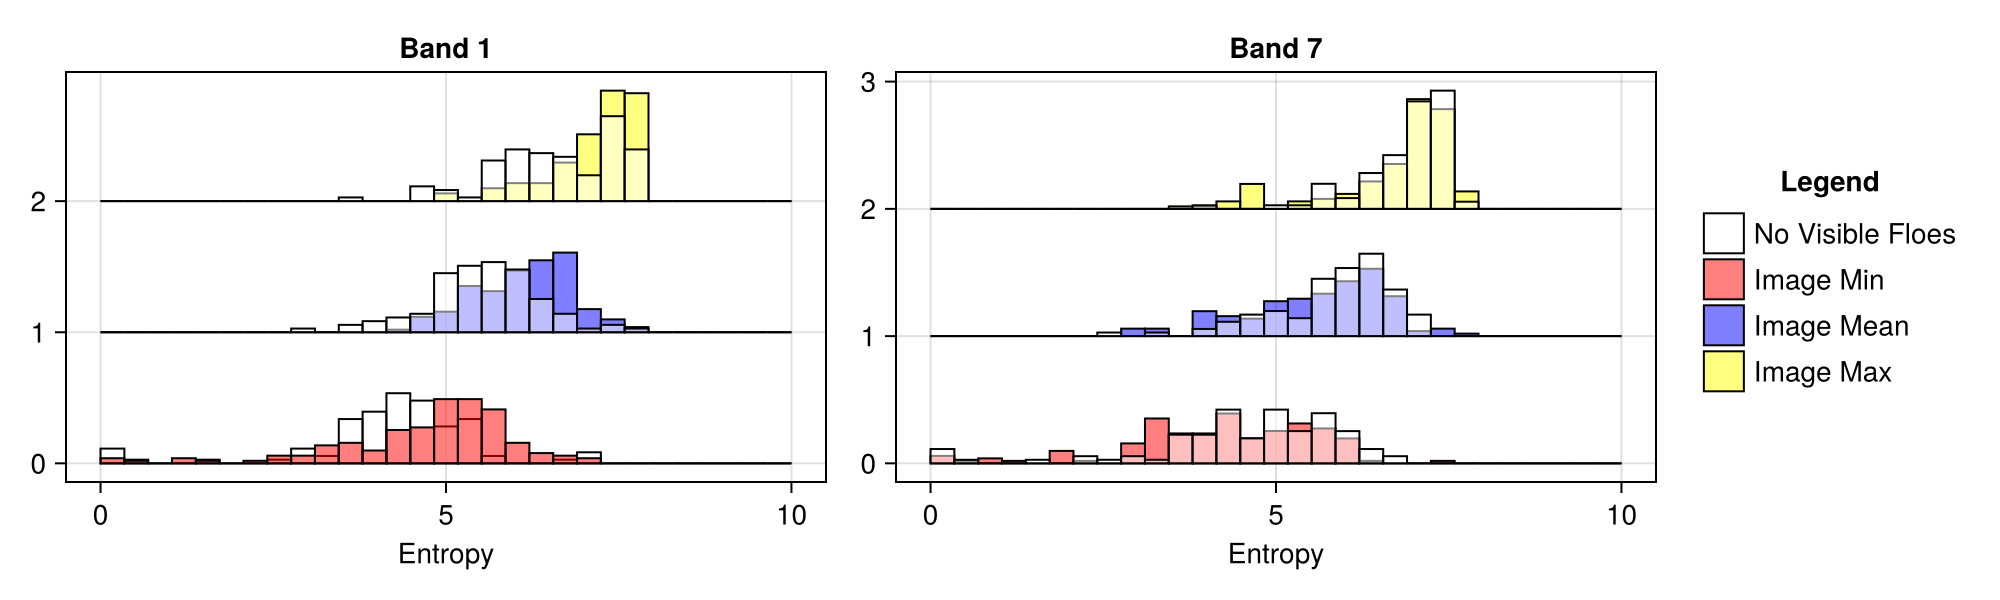

In [402]:
f = Figure(size=(1000, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Band 1", xlabel="Entropy")
ax2 = CairoMakie.Axis(f[1,2], title="Band 7", xlabel="Entropy")

bins = range(0, 10, 30)
idx_vis = df_training.visible_floes .== "yes"
idx_novis = df_training.visible_floes .== "no"

hist!(ax1, df_training[idx_novis, :image_min_b1_entropy], bins = bins, normalization = :pdf,
    label = "No Visible Floes", strokewidth = 1, strokecolor = :black, color=(:white, 0.5))
hist!(ax1, df_training[idx_vis, :image_min_b1_entropy], bins = bins, normalization = :pdf,
    label = "Image Min", strokewidth = 1, strokecolor = :black, color=(:red, 0.5))

hist!(ax2, df_training[idx_vis, :image_min_b7_entropy], bins = bins, normalization = :pdf,
    label="Image Min", color = (:red, 0.5), strokewidth = 1, strokecolor = :black)
hist!(ax2, df_training[idx_novis,  :image_min_b7_entropy], bins = bins, normalization = :pdf,
    label=nothing, color = (:white, 0.5), strokewidth = 1, strokecolor = :black)


hist!(ax1, df_training[idx_vis, :image_mean_b1_entropy], bins = bins, normalization = :pdf, offset=1,
    label = "Image Mean", strokewidth = 1, strokecolor = :black, color=(:blue, 0.5))
hist!(ax1, df_training[idx_novis, :image_mean_b1_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=1)

hist!(ax2, df_training[idx_vis, :image_mean_b7_entropy], bins = bins, normalization = :pdf, offset=1,
    label="Image Mean", color = (:blue, 0.5), strokewidth = 1, strokecolor = :black)
hist!(ax2, df_training[idx_novis, :image_mean_b7_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=1)


hist!(ax1, df_training[idx_vis, :image_max_b1_entropy], bins = bins, normalization = :pdf, offset=2,
    label = "Image Max", strokewidth = 1, strokecolor = :black, color=(:yellow, 0.5))
hist!(ax1, df_training[df_training.visible_floes .== "no", :image_max_b1_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=2)

hist!(ax2, df_training[idx_vis, :image_max_b7_entropy], bins = bins, normalization = :pdf, offset=2,
    label="Image Max", color = (:yellow, 0.5), strokewidth = 1, strokecolor = :black)
hist!(ax2, df_training[idx_novis, :image_max_b7_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=2)


f[1,3] = Legend(f, ax1, "Legend", framevisible = false)

f

# Results: Entropy analysis
I looked at the image-mean, floe-mean, and cloud-mean entropy for Band 1 and Band 7. I also split the floe data into non-obscured, moderate obscuration, and heavy obscuration (though this is still image-wide, not floe by floe). Let's take a look at some specific cases.

Case 19: Potentially detectable floes.  
Case 56: 
Case 95: 

Show: Image, Intersection of labels and cloud mask, 

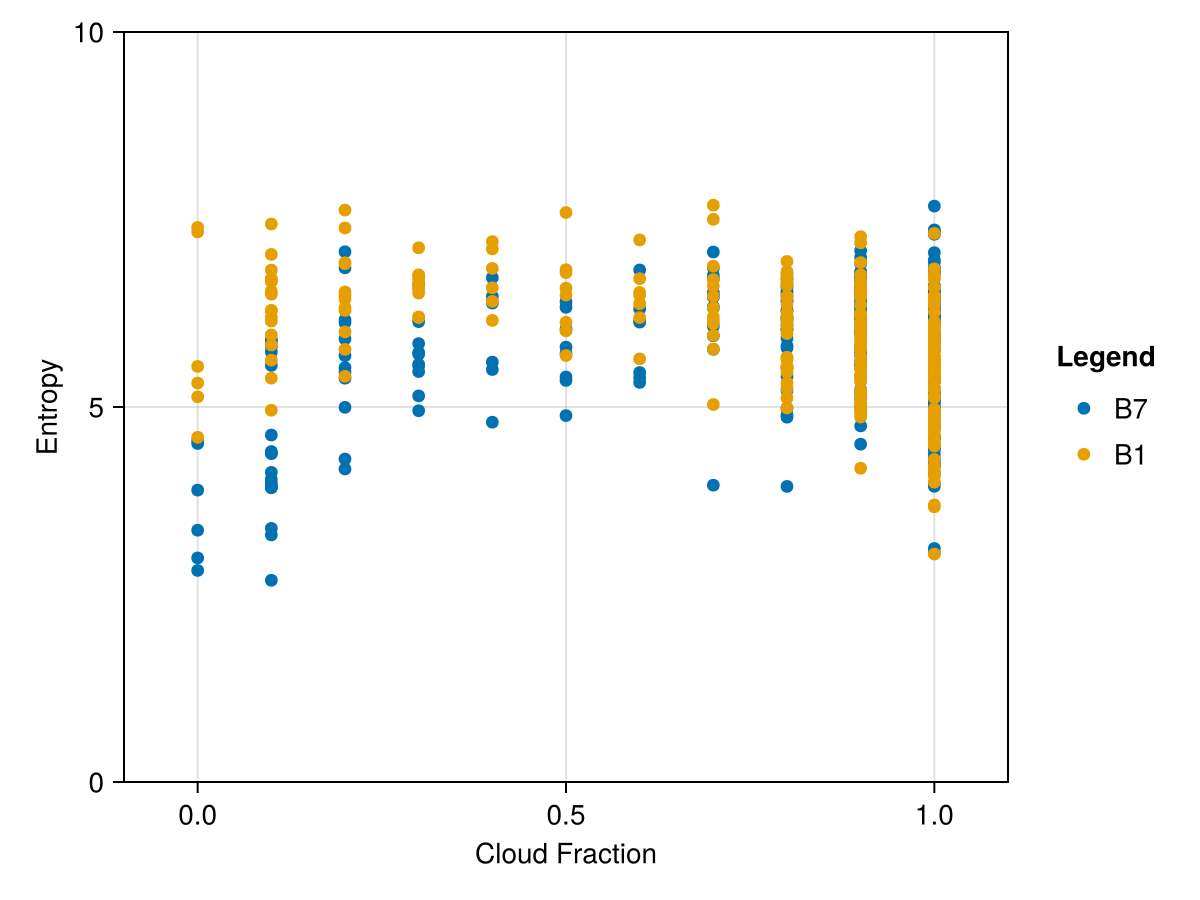

In [403]:
f = Figure()
ax = CairoMakie.Axis(f[1,1], ylabel="Entropy", xlabel="Cloud Fraction")
plot!(ax, df_training[:, :cloud_fraction_manual], 
    df_training[:, :image_mean_b7_entropy], marker=:circle, label="B7")
plot!(ax, df_training[:, :cloud_fraction_manual], 
    df_training[:, :image_mean_b1_entropy], marker=:circle, label="B1")
f[1,2] = Legend(f, ax, "Legend", framevisible = false)
xlims!(ax, (-0.1, 1.1))
ylims!(ax, (0, 10))
f

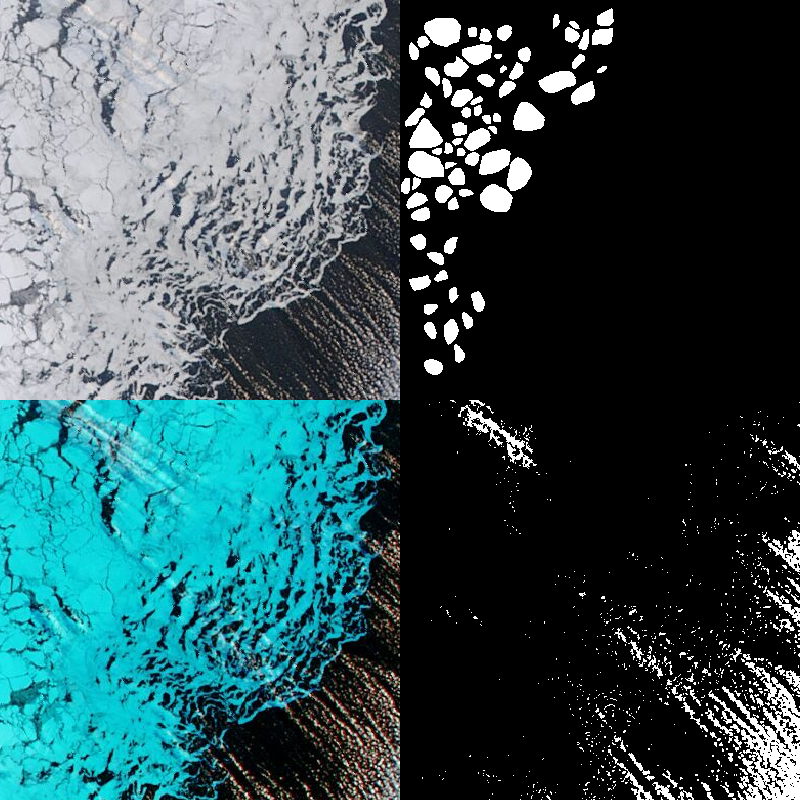

In [482]:
cn = 25
tc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "truecolor", tc_paths[cn*2 - 1]))
fc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "falsecolor", fc_paths[cn*2 - 1]))
lb_path = replace(replace(fc_paths[cn*2 - 1], ".aqua.falsecolor.250m.tiff" => "-aqua-binary_floes.png"), "-100km" => "")

lb_img = IceFloeTracker.load(joinpath(data_loc, "validation_dataset", "binary_floes", lb_path))
man_labels = channelview(lb_img)[1,:,:] .> 0;

cloudmask = .!IceFloeTracker.create_cloudmask(fc_img; prelim_threshold=53/255.,
    band_7_threshold=130/255.,
    band_2_threshold=169/255.,
    ratio_lower=0.0,
    ratio_upper=0.53)
Images.mosaicview(tc_img,fc_img, Gray.(man_labels),  Gray.(cloudmask), nrow=2)

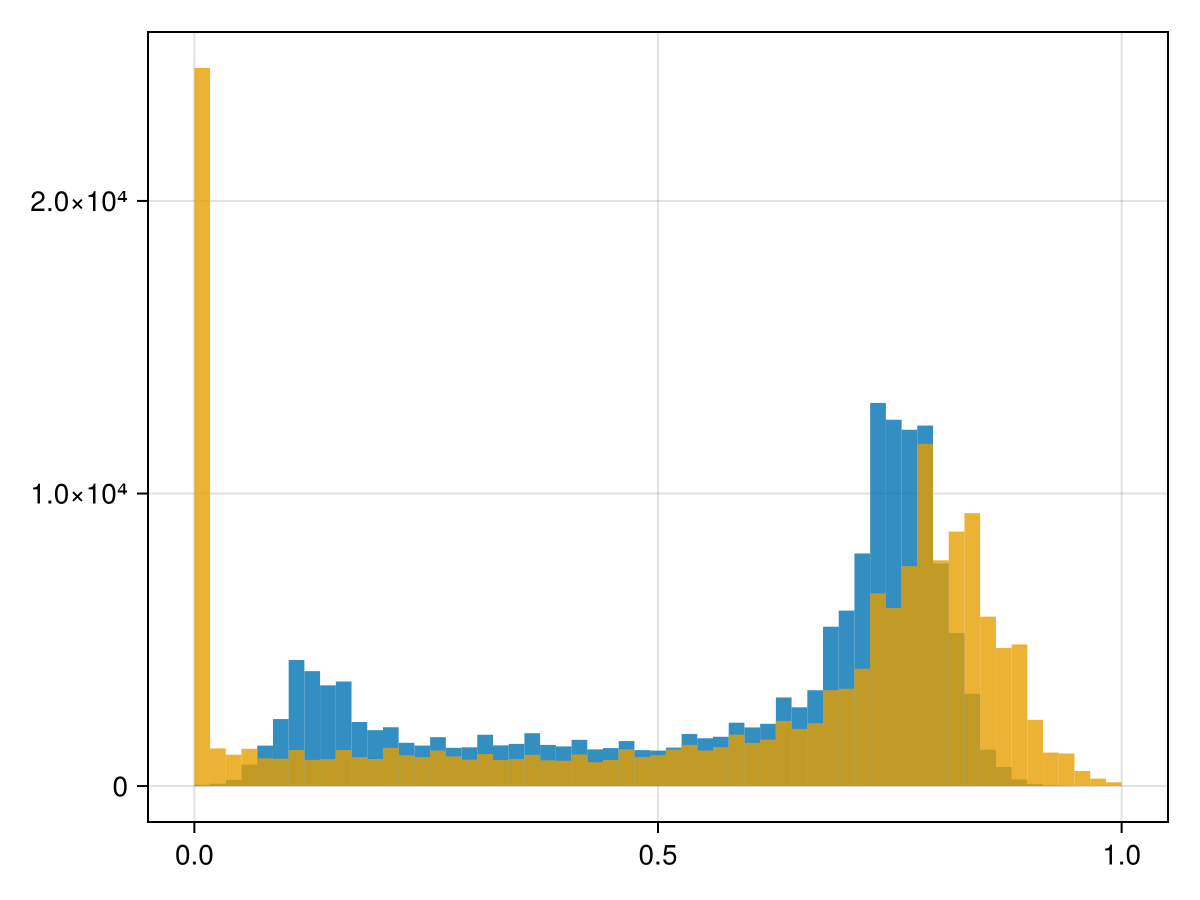

In [483]:
imgo = adjust_histogram(RGB.(tc_img), LinearStretching((0.2, 0.9) => (0, 1)))

f = Figure()
ax1 = f[1,1]
hist(ax1, vec(red.(tc_img)), bins=range(0, 1, 60))
hist!(ax1, vec(red.(imgo)), bins=range(0, 1, 60))
f

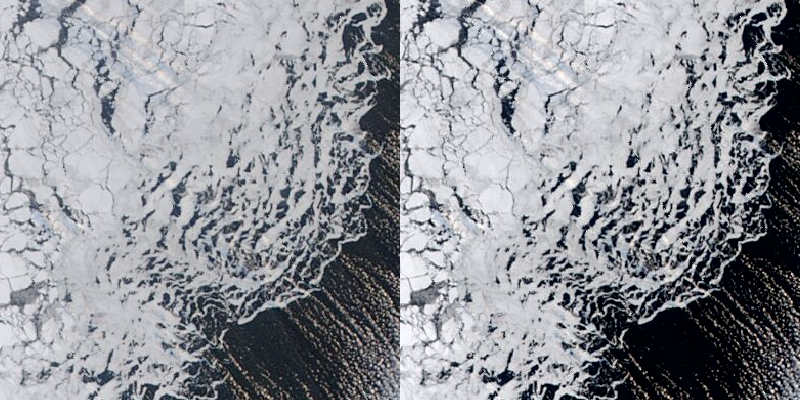

In [484]:
Images.mosaicview(tc_img, imgo, nrow=1)

In [485]:
prelim_sizes = size(tc_img) .÷ 4
tiles = IceFloeTracker.get_tiles(tc_img, prelim_sizes[1] + 1);

cloud_fraction = zeros(size(tc_img))
b7_entropy = zeros(size(tc_img))
b1_entropy = zeros(size(tc_img))

for tile in tiles
    cloud_fraction[tile...] .= mean(cloudmask[tile...])
    b7_entropy[tile...] .= Images.entropy(red.(fc_img[tile...]))
    b1_entropy[tile...] .= Images.entropy(blue.(fc_img[tile...]))
end


In [486]:
function _SegmentedImage(image, image_indexmap)
    """Literally just what is in the ImageSegmentation library, I don't know why it
    doesn't work out of the box."""
    _segment_labels = Set(image_indexmap)
    _segment_labels = collect(_segment_labels)
    _segment_means = Dict{Int,float64(RGB)}()
    _segment_pixel_count = Dict{Int,Int}()
    
    for i in _segment_labels
        _segment_means[i] = zero(float64(RGB))
        _segment_pixel_count[i] = 0
    end
    
    for p in eachindex(image, image_indexmap)
        label = image_indexmap[p]
        _segment_means[label] += image[p]
        _segment_pixel_count[label] += 1
    end
    for i in _segment_labels
        _segment_means[i] /= _segment_pixel_count[i]
    end
    
    return SegmentedImage(image_indexmap, _segment_labels, _segment_means, _segment_pixel_count)
end

_SegmentedImage (generic function with 1 method)

In [487]:
t = _SegmentedImage(Gray.(b1_entropy ./ maximum(b1_entropy)), label_components(man_labels))

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 71

In [488]:
using Random
# Assign random colors to each segment (useful if viewing cluster results)
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end
function view_seg_random(s)
    map(i->get_random_color(i), labels_map(s))
end

view_seg_random (generic function with 1 method)

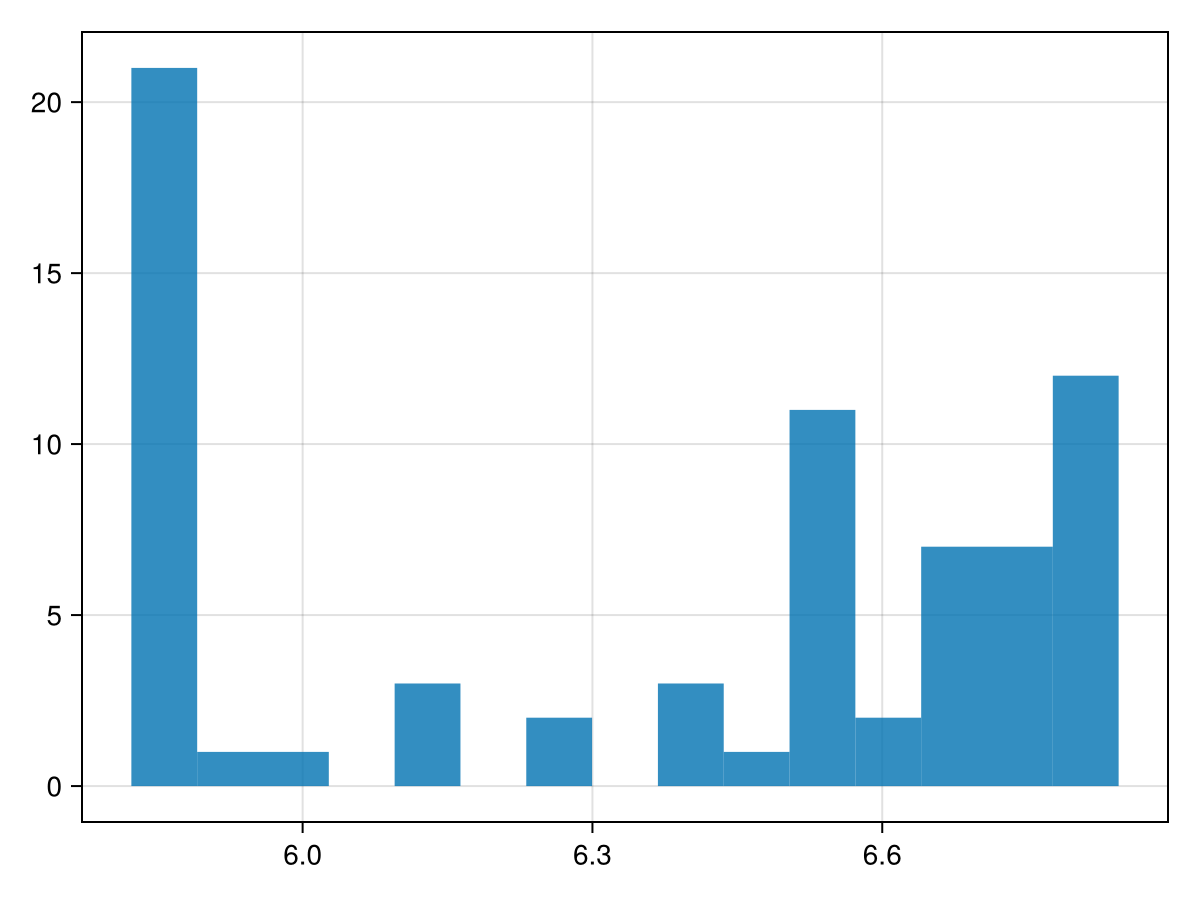

In [489]:
E = maximum(b1_entropy)
mean_entropy = [Float64(Gray(x)) * E for (s, x) in t.segment_means]
hist(mean_entropy)

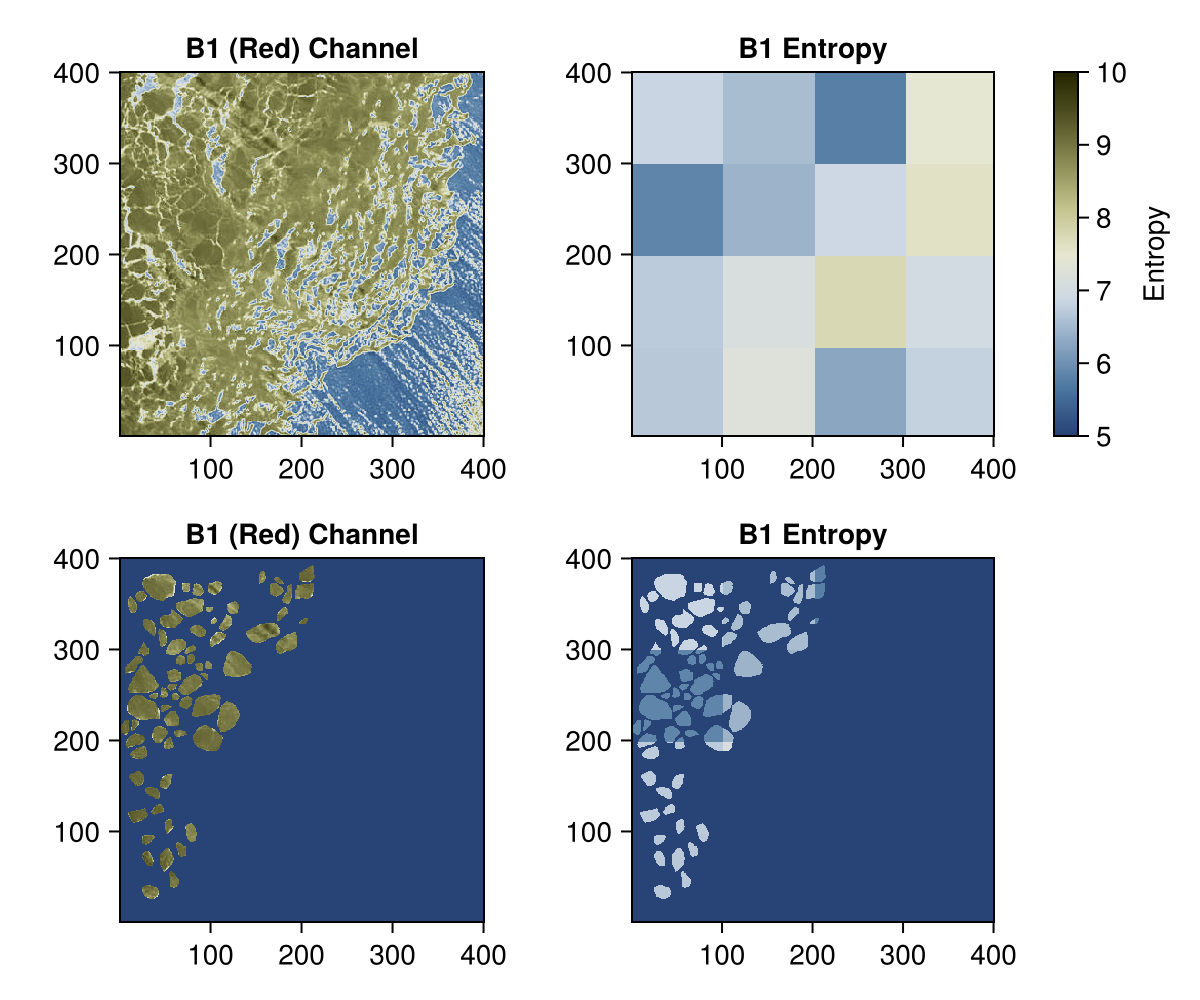

In [493]:
f = Figure(size=(600, 500))

ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title="B1 (Red) Channel")
ax2 = CairoMakie.Axis(f[1, 2], aspect = 1, title="B1 Entropy")
ax3 = CairoMakie.Axis(f[2, 1], aspect = 1, title="B1 (Red) Channel")
ax4 = CairoMakie.Axis(f[2, 2], aspect = 1, title="B1 Entropy")

heatmap!(ax1, transpose(red.(tc_img)[end:-1:1, :]), colorrange=(0, 1), colormap=:broc10)
heatmap!(ax2, transpose(b1_entropy[end:-1:1, :]), colorrange=(5, 10), colormap=:broc10)
Colorbar(f[1, 3], limits=(5, 10), colormap=:broc10,
    vertical=true, label="Entropy")

heatmap!(ax3, transpose((red.(tc_img) .* man_labels)[end:-1:1, :]), colorrange=(0, 1), colormap=:broc10)
heatmap!(ax4, transpose((b1_entropy .* man_labels)[end:-1:1, :]) , colorrange=(5, 10), colormap=:broc10)

f

In [ ]:
hist(vec